In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from darts.models import NBEATSModel
from darts import TimeSeries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_orig = pd.read_csv('./data/preprocessed_football.csv')
df_orig = df_orig[df_orig['Comp'] == 0]
df_orig = df_orig[df_orig['Squad'] == 0]
df = df_orig.drop(['Comp', 'LgRank', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'MP', 'Squad'], axis=1)

df.iloc[1:, :]
df['Season_n'] = df['Season'].to_numpy()[::-1]
df['Pts_n'] = df['Pts'].to_numpy()[::-1]
df = df.iloc[:-1, :]
df = df[['Season_n', 'Pts_n']]
df.head()

,Season_n,Pts_n
134,1988,46.0
135,1989,50.0
136,1990,47.0
137,1991,53.0
138,1992,43.0


In [4]:
df = df_orig.drop(['Squad', 'Comp', 'Attendance', 'Goalkeeper', 'Top Team Scorers', 'Top Team Goals'], axis=1)

# df['Season_n'] = df['Season'].to_numpy()[::-1]
# df['Pts_n'] = df['Pts'].to_numpy()[::-1]
df = df.iloc[::-1, :]
df = df.iloc[:-1, :]
df.drop(['Season'], axis=1, inplace=True)
scale_w = np.full((len(df), 1), fill_value=3)
scale_w[:7] = 2
df['Scale_w'] = scale_w
df.head(10)

,LgRank,MP,W,D,L,GF,GA,GD,Pts,Scale_w
168,4.0,38.0,19.0,8.0,11.0,69.0,45.0,24.0,46.0,2
167,4.0,38.0,20.0,10.0,8.0,55.0,35.0,20.0,50.0,2
166,2.0,38.0,17.0,13.0,8.0,52.0,28.0,24.0,47.0,2
165,3.0,38.0,24.0,5.0,9.0,67.0,35.0,32.0,53.0,2
164,6.0,38.0,16.0,11.0,11.0,52.0,42.0,10.0,43.0,2
163,12.0,38.0,13.0,9.0,16.0,54.0,54.0,0.0,35.0,2
162,14.0,38.0,13.0,9.0,16.0,56.0,54.0,2.0,35.0,2
161,1.0,42.0,26.0,9.0,7.0,75.0,32.0,43.0,87.0,3
160,5.0,42.0,20.0,11.0,11.0,76.0,64.0,12.0,71.0,3
159,7.0,38.0,16.0,12.0,10.0,79.0,56.0,23.0,60.0,3


In [5]:
def predict_exo(train_exo, method, val_len, X_val=None, plot=True, p=10, d=1, q=1):
    result = pd.DataFrame()
    for col in train_exo.columns:
        if method == "arima":
            model = ARIMA(train_exo[col], order=(p,d,q))
            model.initialize_approximate_diffuse()
            model = model.fit()
            forecast = model.forecast(steps=val_len)
            result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        elif method == "texp":
            model = ExponentialSmoothing(train_exo[col], trend='add', seasonal='add', seasonal_periods=12)
            forecast = model.fit().forecast(steps=val_len)
            result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        elif method == "mixed":
            if col in ['Perak_Area_ma', 'Perak_Area_npa', 'Perak_Area_rpa', 'Perak_Area_ma_new']:
                model = ARIMA(train_exo[col], order=(p,d,q))
                model.initialize_approximate_diffuse()
                model = model.fit()
                forecast = model.forecast(steps=val_len)
                result[col] = forecast
            else:
                model = ExponentialSmoothing(train_exo[col], trend='add', seasonal='add', seasonal_periods=12)
                forecast = model.fit().forecast(steps=val_len)
                result[col] = forecast
            if plot:
                plt.figure()
                sns.lineplot(data=train_exo[col], label=col)
                sns.lineplot(data=forecast, label='Forecast')
                sns.lineplot(data=X_val[col], label='gt')
        else:
            raise NotImplementedError
    return result

In [6]:
y = df['Pts']
X = df.drop(['Pts'], axis=1)
y.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)
X_train, X_val, y_train, y_val = X.iloc[:-4, :], X.iloc[-4:, :], y.iloc[:-4], y.iloc[-4:]

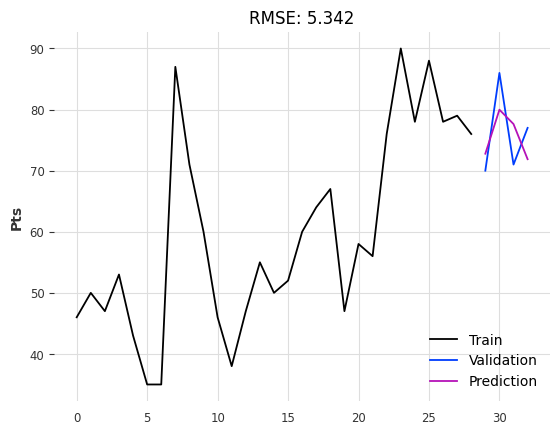

In [11]:
# Approach description:
# try predict wins and draws,
# then calculate total points by the following formula:
# Pts = 3W + D
import warnings
from tqdm import tqdm

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    y1 = df['W']
    y2 = df['D']
    X = df.drop(['Pts', 'MP', 'Scale_w'], axis=1)
    X1 = X.drop(['W'], axis=1)
    X2 = X.drop(['D'], axis=1)
    y1.reset_index(drop=True, inplace=True)
    y2.reset_index(drop=True, inplace=True)
    X1.reset_index(drop=True, inplace=True)
    X2.reset_index(drop=True, inplace=True)
    X1_train, X1_val, X2_train, X2_val, y1_train, y1_val, y2_train, y2_val = X1.iloc[:-4, :], X1.iloc[-4:, :], X2.iloc[:-4, :], X2.iloc[-4:, :], y1.iloc[:-4], y1.iloc[-4:], y2.iloc[:-4], y2.iloc[-4:]

    # results = {}
    # for a in tqdm(range(0, 10)):
    #     for b in range(0, 10):
    #         for c in range(0, 10):
    model_w = SARIMAX(y1_train, X1_train, order=(0, 0, 9), seasonal_order=(0, 0, 0, 12))
    model_w.initialize_approximate_diffuse()
    model_w = model_w.fit(disp=False)
    
    model_d = SARIMAX(y2_train, X2_train, order=(0, 0, 9), seasonal_order=(0, 0, 0, 12))
    model_d.initialize_approximate_diffuse()
    model_d = model_d.fit(disp=False)
    
    
    X1_val_pred = predict_exo(X1_train, 'texp', len(y1_val), X1_val, plot=False)
    X2_val_pred = predict_exo(X2_train, 'texp', len(y2_val), X2_val, plot=False)
    
    res_w = model_w.predict(start=len(y1_train), end=len(y1_train)+len(y1_val)-1, exog=X1_val_pred)
    res_d = model_d.predict(start=len(y2_train), end=len(y2_train)+len(y2_val)-1, exog=X2_val_pred)
    
    
    final_res = pd.DataFrame()
    final_res['pts'] = res_w * 3 + res_d
    rmse = mean_squared_error(y1_val*3 + y2_val, final_res['pts']) ** 0.5
    # results[rmse] = (a, b, c)
        # print('RMSE:', rmse)
    
    final_res.set_index(y1_val.index)
    plt.figure()
    sns.lineplot(data=y_train, label='Train')
    sns.lineplot(data=y1_val*3 + y2_val, label='Validation')
    sns.lineplot(data=final_res['pts'], label='Prediction').set(title=f'RMSE: {round(rmse, 3)}')
    # plt.savefig('results.png')
    plt.show()

In [10]:
top_5 = sorted(results)
for k in top_5:
    print(round(k, 3), results[k])

5.342 (0, 0, 9)
5.486 (1, 0, 9)
5.879 (5, 0, 9)
5.987 (9, 0, 9)
6.002 (8, 0, 9)
6.009 (7, 0, 9)
6.572 (8, 4, 4)
6.737 (4, 0, 9)
6.745 (8, 3, 0)
6.767 (2, 1, 9)
6.772 (0, 1, 9)
6.772 (1, 1, 9)
6.794 (9, 3, 9)
6.796 (9, 3, 1)
6.799 (2, 2, 8)
6.814 (9, 3, 5)
6.835 (6, 1, 9)
6.839 (3, 1, 9)
6.855 (9, 2, 4)
6.866 (7, 1, 9)
6.868 (5, 1, 9)
6.87 (8, 1, 9)
6.872 (9, 1, 8)
6.873 (4, 1, 9)
6.879 (9, 1, 4)
6.88 (9, 2, 6)
6.882 (9, 1, 1)
6.883 (9, 2, 5)
6.895 (9, 1, 3)
6.897 (9, 1, 9)
6.902 (9, 3, 4)
6.91 (9, 1, 6)
6.911 (1, 0, 6)
6.913 (3, 0, 9)
6.913 (1, 3, 9)
6.916 (9, 1, 7)
6.918 (0, 3, 9)
6.92 (9, 1, 2)
6.957 (9, 1, 0)
6.974 (9, 2, 8)
6.988 (9, 2, 3)
6.991 (8, 6, 2)
6.992 (9, 3, 8)
7.0 (7, 6, 0)
7.015 (6, 3, 9)
7.029 (9, 4, 1)
7.029 (7, 3, 9)
7.031 (5, 1, 7)
7.033 (9, 3, 0)
7.047 (9, 2, 7)
7.06 (8, 1, 8)
7.094 (3, 2, 9)
7.095 (8, 3, 8)
7.098 (5, 1, 8)
7.099 (9, 2, 2)
7.11 (4, 3, 9)
7.115 (3, 3, 9)
7.124 (9, 3, 2)
7.131 (9, 2, 9)
7.131 (9, 2, 1)
7.131 (8, 2, 0)
7.132 (7, 3, 2)
7.141 (2, 1, 8)
